In [50]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import color, util, transform as trans, filters, feature
import os
from scipy import ndimage, signal
from sklearn import cluster

In [2]:
images_path = os.path.join('dataset', 'images')

def get(filename):
    return np.array(Image.open(os.path.join(images_path, filename)))

def by_id(i):
    return get(f'{i}.jpg')

def random_images(k=1):
    return tuple(map(get, np.random.choice(os.listdir(images_path), k)))

def hsv_gray(image):
    return color.rgb2gray(color.rgb2hsv(image))

def levels(image, f=np.nansum):
    return f(image, axis=0), f(image, axis=1)

def freqs(image):
    w, h = image.shape
    freq_x = np.fft.fftfreq(w, 1)
    freq_y = np.fft.fftfreq(h, 1)
    fft_x = np.abs(np.fft.fft(np.nansum(image, axis=1)))
    fft_y = np.abs(np.fft.fft(np.nansum(image, axis=0)))
    vals_x, vals_y = freq_x[fft_x == np.sort(fft_x)[-2]], freq_y[fft_y == np.sort(fft_y)[-2]]
    return np.abs(vals_x[0]), np.abs(vals_y[0])


def fft2d(image):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image)))

def ifft2d(image):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(image)))

def ftfilter(fft, xi=0, xf=1, yi=0, yf=1):
    xi, xf = int(xi*fft.shape[0]), int(xf*fft.shape[0])
    yi, yf = int(yi*fft.shape[1]), int(yf*fft.shape[1])
    x, y = np.meshgrid(np.arange(0, fft.shape[0]), np.arange(0, fft.shape[1]))
    f = np.vectorize(lambda x, y: xi <= x <= xf and yi <= y <= yf)
    return np.where(f(x, y), fft, 0)

def radfilter(fft, rf, ri=0):
    x, y = np.meshgrid(np.arange(0, fft.shape[0]), np.arange(0, fft.shape[1]))
    R = np.sqrt((x - fft.shape[0])**2 + (y - fft.shape[1])**2)
    return np.where(np.logical_and(ri <= R, R <= rf), fft, 0)

# Fourier 1D

## Algoritmo

In [2]:
w, h = size = np.array([256, 256])
dx, dy = size/np.random.randint(5, 20, 2)
dx, dy

(19.692307692307693, 21.333333333333332)

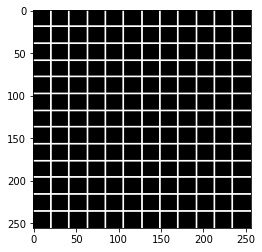

In [3]:
l = 2 # pixels
image = np.zeros(size)
for x in np.arange(0, w, dx):
    image[int(x)-l//2:int(x)+l//2] = 1
for y in np.arange(0, h, dy):
    image[:, int(y)-l//2:int(y)+l//2] = 1
    
plt.imshow(image, cmap='gray')
plt.show()

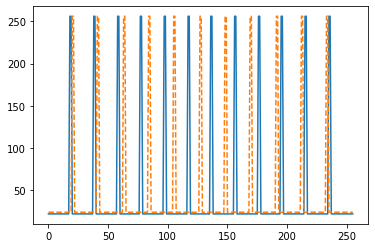

In [4]:
plt.plot(np.sum(image, axis=1))
plt.plot(np.sum(image, axis=0), '--')
plt.show()

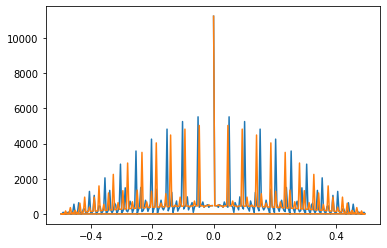

In [5]:
t = np.arange(0, w)
freq_x = np.fft.fftfreq(w, 1)
freq_y = np.fft.fftfreq(h, 1)
fft_x = np.abs(np.fft.fft(np.sum(image, axis=1)))
fft_y = np.abs(np.fft.fft(np.sum(image, axis=0)))
plt.plot(freq_x, fft_x)
plt.plot(freq_y, fft_y)
plt.show()

In [6]:
vals_x, vals_y = freq_x[fft_x == np.sort(fft_x)[-2]], freq_y[fft_y == np.sort(fft_y)[-2]]
vals_x, vals_y

(array([ 0.05078125, -0.05078125]), array([ 0.046875, -0.046875]))

In [7]:
dx_pred = (1/vals_x[vals_x > 0])[0]
dy_pred = (1/vals_y[vals_y > 0])[0]
dx_pred, dy_pred

(19.692307692307693, 21.333333333333332)

In [8]:
(dx - dx_pred)/dx*100, (dy - dy_pred)/dy*100

(0.0, 0.0)

In [9]:
ft = np.fft.ifftshift(image)
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)

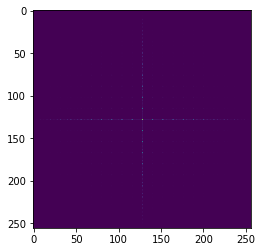

In [10]:
plt.imshow(np.abs(ft))

## Implementação

In [11]:
IMAGES_PATH = os.path.join('dataset', 'images')
img = np.array(Image.open('0.jpg'))

In [36]:
def get_freq(image):
    w, h = image.shape
    freq_x = np.fft.fftfreq(w, 1)
    freq_y = np.fft.fftfreq(h, 1)
    fft_x = np.abs(np.fft.fft(np.nansum(image, axis=1)))
    fft_y = np.abs(np.fft.fft(np.nansum(image, axis=0)))
    vals_x, vals_y = freq_x[fft_x == np.sort(fft_x)[-2]], freq_y[fft_y == np.sort(fft_y)[-2]]
    return np.abs(vals_x[0]), np.abs(vals_y[0])

15.058823529411764 16.0


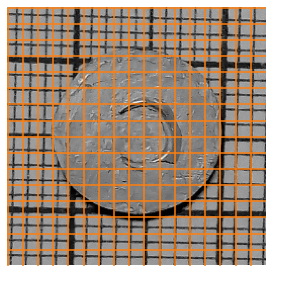

In [37]:
plt.figure(figsize=(5, 5))
image = color.rgb2gray(img)
plt.imshow(image, cmap='gray')
fx, fy = get_freq(image)
print(1/fx, 1/fy)
plt.vlines(np.arange(0, 256, 1/fx), 0, 256, color='tab:orange')
plt.hlines(np.arange(0, 256, 1/fy), 0, 256, color='tab:orange')
plt.axis('off')
plt.show()

15.0 14.937500000000002


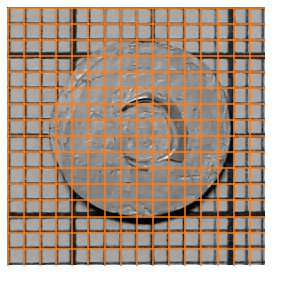

In [38]:
plt.figure(figsize=(5, 5))
image = trans.rotate(color.rgb2gray(img), 1.3, mode='constant', cval=np.nan)
image = image[10:-6, 5:-12]
plt.imshow(image, cmap='gray')
fx, fy = get_freq(image)
print(1/fx, 1/fy)
w, h = image.shape
plt.vlines(np.arange(0, w, 1/fx), 0, w, color='tab:orange')
plt.hlines(np.arange(0, h, 1/fy), 0, h, color='tab:orange')
plt.axis('off')
plt.show()

# Transformação de Hough

$$
x\sin\theta - y\cos\theta + \rho = 0
$$

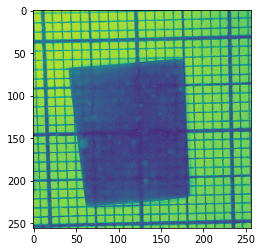

In [91]:
image = random_images()[0]
imgray = color.rgb2gray(image)
plt.imshow(imgray)

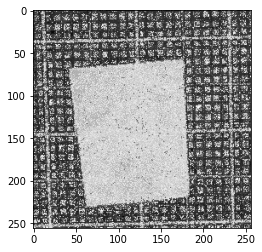

In [219]:
#thres = filters.threshold_otsu(ndimage.sobel(imgray))
edges = hsv_gray(ndimage.laplace(image))#feature.canny(imgray)
plt.imshow(edges, cmap='gray')

In [206]:
lines = trans.probabilistic_hough_line(edges,line_length=5, line_gap=5)

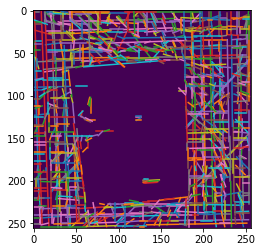

In [207]:
thetas = []
plt.imshow(edges*0)
for line in lines:
    (x0, y0), (x1, y1) = line
    plt.plot((x0, x1), (y0, y1))
    thetas.append(np.abs(np.arctan2(np.abs(y1-y0), np.abs(x1-x0))))

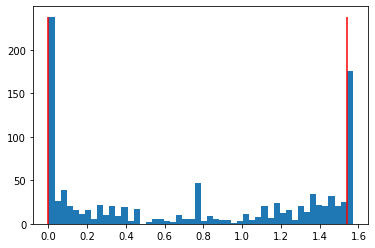

In [208]:
X = np.abs(thetas)
hist, bins, _ = plt.hist(X, bins=50)
maxs = bins[:-1][np.isin(hist, np.sort(hist)[::-1][:2])]
plt.vlines(maxs, 0, hist.max(), color='red')
plt.show()

In [209]:
print(maxs)
angle = np.degrees(maxs.max() - maxs.min())
print(angle)
print(np.abs(90-angle)/90*100)

[0.        1.5393804]
88.2
1.999999999999997


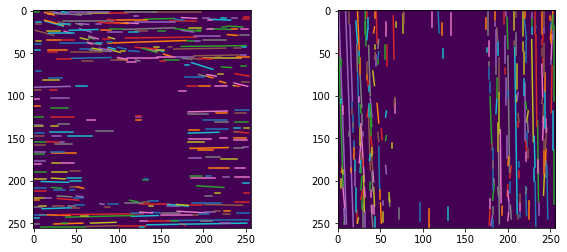

In [210]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(edges*0)
ax2.imshow(edges*0)

X, Y = [], []
for line in lines:
    (x0, y0), (x1, y1) = line
    angle = np.abs(np.arctan2(y1-y0, x1-x0))
    if maxs[0]:
        if maxs[0]*0.9 < angle < maxs[0]*1.1:
            ax1.plot((x0, x1), (y0, y1))
    else:
        if angle < np.abs(maxs[1]-np.pi/2)*1.1 or np.pi*0.9 < angle < np.pi*1.1:
            ax1.plot((x0, x1), (y0, y1))
            Y.append((y0+y1)/2)
    if maxs[1]*0.9 < angle < maxs[1]*1.1:
        ax2.plot((x0, x1), (y0, y1))
        X.append((x0+x1)/2)
X, Y = np.array(X), np.array(Y)

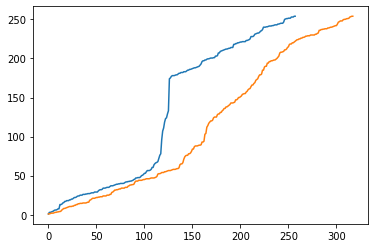

In [211]:
plt.plot(np.sort(X))
plt.plot(np.sort(Y))

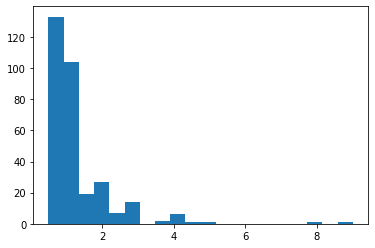

In [213]:
plt.hist([np.abs(Y[Y > y] - y).min() for y in Y if len(Y[Y > y])], bins=20)
plt.show()

# Fourier 2D

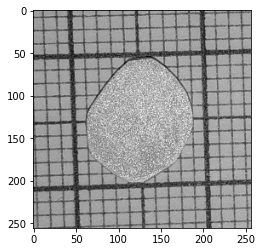

In [72]:
image = random_images()[0]
imgray = color.rgb2gray(image)
plt.imshow(imgray, cmap='gray')

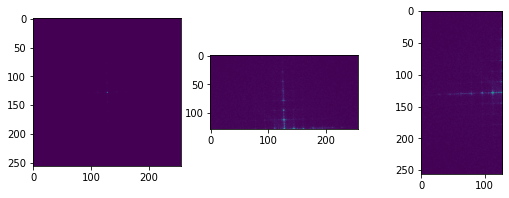

In [98]:
fft = np.abs(fft2d(imgray))
xfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[0], 1))
yfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[1], 1))
yquad = fft[:fft.shape[0]//2]
xquad = fft[:, :fft.shape[1]//2]
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(fft)
axs[1].imshow(yquad)
axs[2].imshow(xquad)

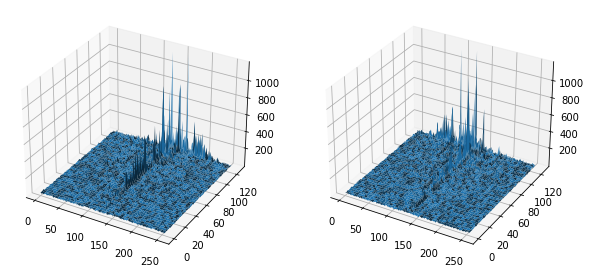

In [74]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.plot_surface(*np.meshgrid(np.arange(0, yquad.shape[1]), np.arange(0, yquad.shape[0])), yquad)
ax2.plot_surface(*np.meshgrid(np.arange(0, xquad.shape[0]), np.arange(0, xquad.shape[1])), xquad.T)

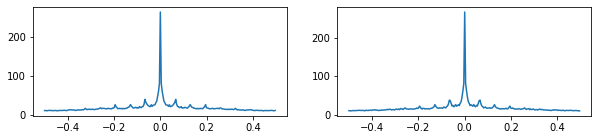

In [99]:
fig, axs = plt.subplots(1, 2, figsize=(10, 2))
ymean = np.mean(fft, axis=1)
xmean = np.mean(fft, axis=0)
axs[0].plot(yfreqs, ymean)
axs[1].plot(xfreqs, xmean)

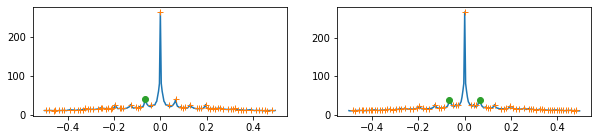

In [101]:
fig, axs = plt.subplots(1, 2, figsize=(10, 2))
(ypeaks, _), (xpeaks, _) = signal.find_peaks(ymean), signal.find_peaks(xmean)
Py = ypeaks[ymean[ypeaks] == ymean[ypeaks][np.isin(ymean[ypeaks], ymean[yfreqs < yfreqs[ymean == ymean[ypeaks].max()][0]])].max()]
Px = xpeaks[xmean[xpeaks] == xmean[xpeaks][np.isin(xmean[xpeaks], xmean[xfreqs < xfreqs[xmean == xmean[xpeaks].max()][0]])].max()]

axs[0].plot(yfreqs, ymean)
axs[0].plot(yfreqs[ypeaks], ymean[ypeaks], '+')
axs[0].plot(yfreqs[Py], ymean[Py], 'o')
axs[1].plot(xfreqs, xmean)
axs[1].plot(xfreqs[xpeaks], xmean[xpeaks], '+')
axs[1].plot(xfreqs[Px], xmean[Px], 'o')

In [102]:
xfreqs[Px][0], xfreqs[Py][0]

(-0.06640625, -0.06640625)

In [70]:
def freq_peaks(image):
    fft = fft2d(image)
    
    xfreqs = np.fft.fftfreq(fft.shape[0], 1)[:fft.shape[0]//2]
    yfreqs = np.fft.fftfreq(fft.shape[1], 1)[:fft.shape[1]//2]
    
    yquad = np.abs(fft)[:fft.shape[0]//2]
    xquad = np.abs(fft)[:, :fft.shape[1]//2]
    
    ymean = np.mean(yquad, axis=1)
    xmean = np.mean(xquad, axis=0)
    
    (ypeaks, _), (xpeaks, _) = signal.find_peaks(ymean), signal.find_peaks(xmean)
    Py = ypeaks[ymean[ypeaks] == ymean[ypeaks].max()]
    Px = xpeaks[xmean[xpeaks] == xmean[xpeaks].max()]
    
    return xfreqs[Px][0], xfreqs[Py][0]